In [3]:
import vtk
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import os

from ipyvtklink.viewer import ViewInteractiveWidget


#### Using the segmentation mask registered to the individual images, render and compute the volume certain anatomical features
1. Segment the structure of interest - simple since you know the pxl value
2. Compute a marching cubes surface on the segmented region
3. Render the volume/surface visualization
4. Compute the volume

In [165]:
# Create a dict of labels and their value
custom_labels = ['lateral ventricle', 'amygdala', 'fourth ventricle', 'thalamus', 'third ventricle', 'hippocampus', 'basal forebrain', 'arbor vita of cerebellum', 'nucleus accumbens', 'globus pallidus']
custom_labels_LR = [side_label for label in custom_labels for side_label in [label + " R", label + " L"]]
common_stuct_start_idx = 251
common_structs = {}

for i, label in enumerate(custom_labels_LR):
    common_structs[label] = common_stuct_start_idx + i

print(common_structs)

# VTK helpers
# Returns the window, renderer, and interactor
def create_render_objs():
    window = vtk.vtkRenderWindow()

    interactor = vtk.vtkRenderWindowInteractor()
    renderer = vtk.vtkRenderer()

    window.AddRenderer(renderer)
    interactor.SetRenderWindow(window)

    return window, renderer, interactor


{'lateral ventricle R': 251, 'lateral ventricle L': 252, 'amygdala R': 253, 'amygdala L': 254, 'fourth ventricle R': 255, 'fourth ventricle L': 256, 'thalamus R': 257, 'thalamus L': 258, 'third ventricle R': 259, 'third ventricle L': 260, 'hippocampus R': 261, 'hippocampus L': 262, 'basal forebrain R': 263, 'basal forebrain L': 264, 'arbor vita of cerebellum R': 265, 'arbor vita of cerebellum L': 266, 'nucleus accumbens R': 267, 'nucleus accumbens L': 268, 'globus pallidus R': 269, 'globus pallidus L': 270}


In [173]:
class anatomical_structure():
    def __init__(self, struct_dict, struct_name, L_or_R, image_path, reader_type, kernel_size, dilate_value, erode_value):
        self.struct_dict = struct_dict
        self.struct_name = struct_name
        self.L_or_R = L_or_R

        self.image_path = image_path
        self.reader_type = reader_type

        self.kernel_size = kernel_size
        self.dilate_value = dilate_value
        self.erode_value = erode_value

    def read_image(self):
        # read image
        if self.reader_type == "DICOM":
            dicom_reader = vtk.vtkDICOMImageReader()
            dicom_reader.SetDirectoryName(self.image_path)
            self.reader = dicom_reader
        else:
            nifti_reader = vtk.vtkNIFTIImageReader()
            nifti_reader.SetFileName(self.image_path)
            self.reader = nifti_reader

        self.reader.Update()

    def threshold_struct(self):
        if self.L_or_R == "L":
            self.visualize_stuct = self.struct_name + " L"
            thresh_value_low = self.struct_dict[self.visualize_stuct]
            thresh_value_high = self.struct_dict[self.visualize_stuct]

        elif self.L_or_R == "R":
            self.visualize_stuct = self.struct_name + " R"
            thresh_value_low = self.struct_dict[self.visualize_stuct]
            thresh_value_high = self.struct_dict[self.visualize_stuct]

        # visualize both
        else:
            thresh_value_low = self.struct_dict[self.struct_name + " R"]
            thresh_value_high = thresh_value_low + 1

        self.thresh = vtk.vtkImageThreshold()
        self.thresh.SetInputConnection(self.reader.GetOutputPort())
        self.thresh.ThresholdBetween(thresh_value_low, thresh_value_high)
        self.thresh.ReplaceInOn()
        self.thresh.SetInValue(1)  # magic number rule exception: will never need to be modified
        self.thresh.ReplaceOutOn()
        self.thresh.SetOutValue(0)  # magic number rule exception: will never need to be modified
        self.thresh.SetOutputScalarTypeToFloat()
        self.thresh.Update()

    def dilate(self):
        # Dilate the image
        self.dilate = vtk.vtkImageDilateErode3D()
        self.dilate.SetInputConnection(self.thresh.GetOutputPort())
        self.dilate.SetKernelSize(*self.kernel_size)
        self.dilate.SetDilateValue(self.dilate_value)
        self.dilate.SetErodeValue(self.erode_value)
        self.dilate.Update()

    def compute_volume(self):
        # compute the volume from the binary voxel mask
        binary_image = self.dilate.GetOutput()
        spacing = binary_image.GetSpacing()
        accumulator = vtk.vtkImageAccumulate()
        accumulator.IgnoreZeroOn()
        accumulator.SetInputData(binary_image)
        accumulator.Update()

        num_voxels = accumulator.GetVoxelCount()
        voxel_volume = spacing[0] * spacing[1] * spacing[2]
        self.volume = num_voxels * voxel_volume

    def compute_relative_volume(self):
        # compute the volume from the binary voxel mask
        binary_image = self.dilate.GetOutput()
        spacing = binary_image.GetSpacing()
        accumulator = vtk.vtkImageAccumulate()
        accumulator.IgnoreZeroOn()
        accumulator.SetInputData(binary_image)
        accumulator.Update()
        num_voxels_in_struct = accumulator.GetVoxelCount()

        # count all non zero voxels in image
        image = self.reader.GetOutput()
        full_brain_accumulator = vtk.vtkImageAccumulate()
        full_brain_accumulator.IgnoreZeroOn()
        full_brain_accumulator.SetInputData(image)
        full_brain_accumulator.Update()
        full_brain_num_voxels = full_brain_accumulator.GetVoxelCount()

        # TODO: needs to be where brain tissue is!!!!
        voxel_volume = spacing[0] * spacing[1] * spacing[2]
        self.volume = num_voxels_in_struct * voxel_volume
        full_brain_volume = full_brain_num_voxels * voxel_volume

        self.relative_volume = self.volume / full_brain_volume
        

    def compute_surface(self):
        # convert the thresholded anatomical structure top a surface object
        self.isosurface = vtk.vtkMarchingCubes()
        self.isosurface.SetInputConnection(self.dilate.GetOutputPort())
        self.isosurface.SetValue(0, 1) # 1 since that's what the thresholding replaced???
        self.isosurface.Update()

    def map_surface(self):
        self.mapper = vtk.vtkPolyDataMapper()
        self.mapper.SetInputConnection(self.isosurface.GetOutputPort())
        self.mapper.ScalarVisibilityOff()

    def compute_surface_actor(self):
        struct_idx = (list(self.struct_dict)).index(self.visualize_stuct)

        # set colour to match labels rendering
        color_series = vtk.vtkColorSeries()
        # choose the vtk colour scheme
        color_series.SetColorScheme(vtk.vtkColorSeries.BREWER_QUALITATIVE_SET3)

        # skip over grey (idx = 8) in colour series
        grey_offset = 0
        num_colours_in_map = color_series.GetNumberOfColors()

        if struct_idx >= 8:
            grey_offset = 1
        if struct_idx >= 8 + num_colours_in_map - 1:
            grey_offset = 2

        colour = color_series.GetColor((struct_idx + grey_offset)  % num_colours_in_map)

        # for first loop over colours
        if struct_idx < (num_colours_in_map - 1):
            scale = 255
        elif struct_idx < 2*(num_colours_in_map - 1):
            scale = 150
        else:
            scale = 5

        colour = (colour.GetRed() / scale, colour.GetGreen() / scale, colour.GetBlue() / scale)
        print(colour)
        self.actor = vtk.vtkActor()
        self.actor.SetMapper(self.mapper)
        self.actor.GetProperty().SetColor(*colour)

        return self.actor

    def compute_text_actor(self):
        self.text_actor = vtk.vtkTextActor()
        self.text_actor.GetTextProperty().SetFontSize(24)
        self.text_actor.GetTextProperty().SetColor(1, 1, 1)
        self.text_actor.SetInput(str(self.visualize_stuct) + " (Volume: " + str(round(self.relative_volume, 3)) + ")")
        text_property = self.text_actor.GetTextProperty()
        text_property.SetFontSize(16)

        return self.text_actor

    def compute_vol_steps(self, vol_type):
        self.read_image()
        self.threshold_struct()
        self.dilate()

        if vol_type == "relative":
            self.compute_relative_volume()
            return self.relative_volume
    
        else:
            self.compute_volume()
            return self.volume
    
    def render_vol_steps(self):
        self.read_image()
        self.threshold_struct()
        self.dilate()
        self.compute_relative_volume()

        self.compute_surface()
        self.map_surface()
        self.compute_surface_actor()
        self.compute_text_actor()

        return self.actor, self.text_actor



In [ ]:
# select structure to render the volume of
render_struct_name = 'lateral ventricle'
render_L_or_R = 'L'

#human_labels_image_path = "./atlases/human_mni_icbm152_CerebrA_tal_nlin_sym_09c.nii" 
human_labels_image_path = "./atlases/human_seg_common_proc.nii" 
mouse_labels_image_path = "./atlases/mouse_seg_common_proc.nii"
human_folder_path = "./data/human/processed_labels/"
mouse_folder_path = "./data/mouse/processed_labels/"

folder_path = human_folder_path
image_path = human_labels_image_path

reader_type = "NIFTY"

# Set morphological operation properties
dilate_value = 1
erode_value = 0
kernel_size = (3, 3, 3)

############################################## params done


In [175]:
# render surface
structure = anatomical_structure(common_structs, render_struct_name, render_L_or_R, image_path, reader_type, kernel_size, dilate_value, erode_value)
actor, text_actor = structure.render_vol_steps()

# Standard rendering set-up objects
window, renderer, interactor = create_render_objs()

# Add actor to the renderer
renderer.AddActor(actor)
renderer.AddActor(text_actor)
    
# Display in external window
window.Render()
interactor.Initialize()
interactor.Start()

# Display inline
#ViewInteractiveWidget(window)


AttributeError: 'anatomical_structure' object has no attribute 'visualize_stuct'

In [ ]:
# compute all volumes
L_or_R = 'both'
volumes = []
# loop over each processed segmentation mask

for i, file_name in enumerate(os.listdir(folder_path)[:1]):
    image_path = folder_path + file_name#"./atlases/mouse_labels_common_proc.nii"
    volumes.append([])
    # loop over each structure
    for struct in custom_labels:
        print(struct)
        structure = anatomical_structure(common_structs, struct, L_or_R, image_path, reader_type, kernel_size, dilate_value, erode_value)
        volume = structure.compute_vol_steps(vol_type="relative")
        volumes[i].append(volume)

    print(volumes)

volumes_np = np.array(volumes)
np.save("./human_struct_volumes", volumes_np)

# NOTE: takes ~10min (on work comp)

In [166]:
# set colour to match labels rendering
color_series = vtk.vtkColorSeries()
# choose the vtk colour scheme
color_series.SetColorScheme(vtk.vtkColorSeries.BREWER_QUALITATIVE_SET3)

# skip over grey (idx = 8) in colour series
grey_offset = 0
num_colours_in_map = color_series.GetNumberOfColors()

num_colours = len(common_structs)
print(num_colours)
np_colours = np.zeros((num_colours, 3))
for i in range(num_colours):
    if i >= 8:
        grey_offset = 1
    if i >= 8 + num_colours_in_map - 1:
        grey_offset = 2

    colour = color_series.GetColor((i + grey_offset)  % num_colours_in_map)

    np_colours[i] = np.array([colour.GetRed(), colour.GetGreen(), colour.GetBlue()]) / 255.0



20


Text(0.5, 1.0, 'Mouse MRIs - common structure volumes')

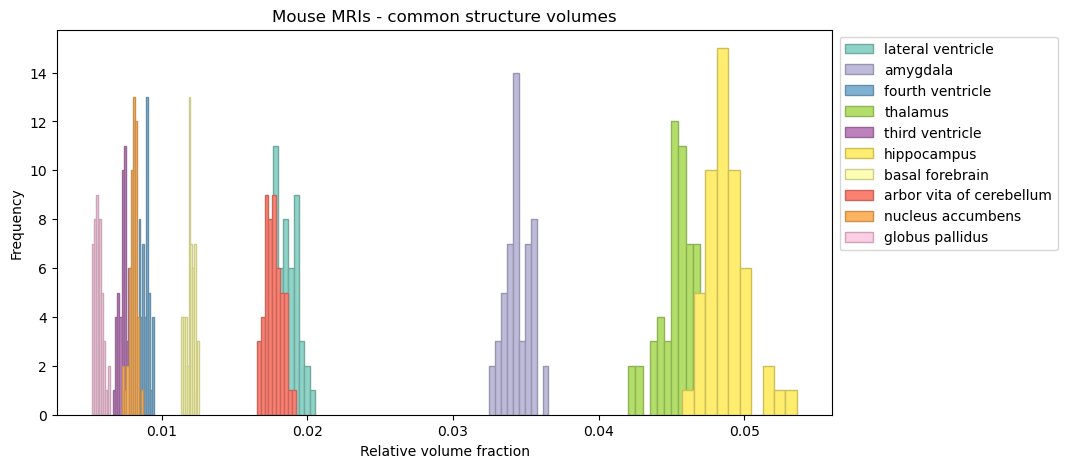

In [168]:
volumes_np = np.load("./metrics_data/mouse_struct_volumes.npy")

#volumes_np = np.load("./metrics_data/human_struct_volumes.npy")

plt.figure(figsize=(10,5))
offset = 0
labels = []
col_num = 1

# plot histograms over the size
for i, struct in enumerate(custom_labels):
    #if struct != "optic tract":
        data = volumes_np[:, i]
        
        plt.hist(data, bins=10, edgecolor=np_colours[2*(i - offset)]*0.8, color=np_colours[2*(i - offset)])
        plt.xlabel("Relative volume fraction")
        plt.ylabel("Frequency")
        labels.append(struct)
    #else: 
    #    offset = 1

plt.legend(labels, loc='upper right', bbox_to_anchor=(1.3, 1))
plt.title("Mouse MRIs - common structure volumes")


In [ ]:
# plot hist of white to grey matter ratio (need volumes of all :()